In [11]:
import os
import pandas as pd

# --- CONFIGURATION ---
BASE_DIR = "/gpfs/accounts/jjparkcv_root/jjparkcv98/minsukc/Coltea-Lung-CT-100W"
CSV_PATH = os.path.join(BASE_DIR, "test_data.csv")
DICOM_DIR = os.path.join(BASE_DIR, "data_dicom")

def count_test_set_dicoms():
    if not os.path.exists(CSV_PATH):
        print(f"❌ Could not find CSV at {CSV_PATH}")
        return

    # Load the 15 test subject IDs [cite: 335, 377]
    df = pd.read_csv(CSV_PATH)
    test_subjects = df.iloc[:, 1].tolist()  # Author code uses 2nd column
    
    total_native = 0
    total_arterial = 0
    total_venous = 0
    
    print(f"📊 Analyzing {len(test_subjects)} test subjects...\n")
    print(f"{'Subject ID':<15} | {'Native Slices':<15} | {'Arterial Slices'} | {'Venous Slices'}")
    print("-" * 50)

    for subj in test_subjects:
        # Construct paths to the DICOM folders
        native_path = os.path.join(DICOM_DIR, subj, "NATIVE", "DICOM")
        venous_path = os.path.join(DICOM_DIR, subj, "VENOUS", "DICOM")
        arterial_path = os.path.join(DICOM_DIR, subj, "ARTERIAL", "DICOM")
        
        # Count files (excluding hidden files)
        n_count = len([f for f in os.listdir(native_path) if os.path.isfile(os.path.join(native_path, f))]) if os.path.exists(native_path) else 0
        a_count = len([f for f in os.listdir(arterial_path) if os.path.isfile(os.path.join(arterial_path, f))]) if os.path.exists(arterial_path) else 0
        v_count = len([f for f in os.listdir(venous_path) if os.path.isfile(os.path.join(venous_path, f))]) if os.path.exists(venous_path) else 0
        
        print(f"{subj:<15} | {n_count:<15} | {a_count} | {v_count}")
        
        total_native += n_count
        total_arterial += a_count
        total_venous += v_count

    print("-" * 50)
    print(f"✅ Total Native Slices:   {total_native}")
    print(f"✅ Total Arterial Slices: {total_arterial}")
    print(f"✅ Total Venous Slices: {total_venous}")
    print(f"📢 Grand Total:           {total_native + total_arterial + total_venous}")
    print(f"\nNOTE: The paper expects roughly 6,042 images for the test set across all phases[cite: 335].")

count_test_set_dicoms()

📊 Analyzing 15 test subjects...

Subject ID      | Native Slices   | Arterial Slices | Venous Slices
--------------------------------------------------
PA04022018      | 154             | 154 | 154
AB17122018      | 101             | 101 | 101
CS18042016      | 139             | 139 | 139
MAF03022021     | 174             | 174 | 174
IM14082017      | 133             | 133 | 133
ME10062020      | 167             | 167 | 167
AM18022017      | 202             | 202 | 202
SF19012021      | 103             | 103 | 103
CV20102015      | 172             | 172 | 172
SE28012021      | 175             | 175 | 175
BM26032018      | 133             | 133 | 133
IA08012021      | 115             | 115 | 115
EM31082020      | 85              | 85 | 85
ME19112020      | 161             | 161 | 161
SM04022021      | 172             | 172 | 172
--------------------------------------------------
✅ Total Native Slices:   2186
✅ Total Arterial Slices: 2186
✅ Total Venous Slices: 2186
📢 Grand Total:       

In [5]:
import os
import glob
import pydicom
import SimpleITK as sitk
import numpy as np

# POINT THIS TO A REAL DICOM FOLDER (e.g., inside 'data_dicom/SubjectX/NATIVE/DICOM')
# Pick any subject that exists in your dataset
# TEST_DICOM_DIR = "/gpfs/accounts/jjparkcv_root/jjparkcv98/minsukc/Coltea-Lung-CT-100W/data_dicom/AB17122018/NATIVE/DICOM"
# TEST_DICOM_DIR = "/gpfs/accounts/jjparkcv_root/jjparkcv98/minsukc/Coltea-Lung-CT-100W/data_dicom/MF04022021/NATIVE/DICOM"
# TEST_DICOM_DIR = "/gpfs/accounts/jjparkcv_root/jjparkcv98/minsukc/Coltea-Lung-CT-100W/data_dicom/PA04022018/NATIVE/DICOM"
TEST_DICOM_DIR = "/gpfs/accounts/jjparkcv_root/jjparkcv98/minsukc/Coltea-Lung-CT-100W/data_dicom/PS26102015/NATIVE/DICOM"

def inspect_dicom_values(dicom_dir):
    print(f"🧐 Inspecting: {dicom_dir}")
    
    # 1. Find a single .dcm file
    dcm_files = glob.glob(os.path.join(dicom_dir, "*.dcm"))
    if not dcm_files:
        # Sometimes they don't have .dcm extension, just grab the first file
        dcm_files = [os.path.join(dicom_dir, f) for f in os.listdir(dicom_dir) if os.path.isfile(os.path.join(dicom_dir, f))]
    
    sample_file = dcm_files[0]
    print(f"📄 Reading File: {os.path.basename(sample_file)}")

    # --- A. PYDICOM (Raw Data) ---
    ds = pydicom.dcmread(sample_file)
    raw_pixels = ds.pixel_array
    
    slope = getattr(ds, 'RescaleSlope', 1)
    intercept = getattr(ds, 'RescaleIntercept', 0)

    print("\n--- [A] PYDICOM (What the Author likely used) ---")
    print(f"Min Value: {raw_pixels.min()}")
    print(f"Max Value: {raw_pixels.max()}")
    print(f"Dtype:     {raw_pixels.dtype}")
    print(f"Rescale Intercept (Tag 0028,1052): {intercept}")
    print(f"Rescale Slope     (Tag 0028,1053): {slope}")
    
    # --- B. SIMPLEITK (What YOU are using) ---
    reader = sitk.ImageFileReader()
    reader.SetFileName(sample_file)
    img = reader.Execute()
    sitk_pixels = sitk.GetArrayFromImage(img)
    
    print("\n--- [B] SimpleITK (What your code produces) ---")
    print(f"Min Value: {sitk_pixels.min()}")
    print(f"Max Value: {sitk_pixels.max()}")
    print(f"Dtype:     {sitk_pixels.dtype}")

    # --- C. VERIFICATION ---
    print("\n--- [C] VERDICT ---")
    
    # Check if SimpleITK equals Raw * Slope + Intercept
    calc_hu = raw_pixels * slope + intercept
    diff = np.abs(sitk_pixels - calc_hu).max()
    
    if raw_pixels.min() >= 0 and sitk_pixels.min() < 0:
        print("🚨 CRITICAL DIFFERENCE FOUND 🚨")
        print(f"Raw DICOM is unsigned (min {raw_pixels.min()}), but SimpleITK shifted it to HU (min {sitk_pixels.min()}).")
        print(f"The author's code `x / 1000 - 1` assumes INPUT IS IN RANGE [0, ~2000].")
        print(f"Your input is in range [{sitk_pixels.min()}, {sitk_pixels.max()}].")
        print("You MUST shift your data before using the author's metrics.")
    else:
        print("Data ranges look similar. The issue might be elsewhere.")

if os.path.isdir(TEST_DICOM_DIR):
    inspect_dicom_values(TEST_DICOM_DIR)
else:
    print(f"❌ Path not found: {TEST_DICOM_DIR}")
    print("Please update 'TEST_DICOM_DIR' to a valid folder.")

🧐 Inspecting: /gpfs/accounts/jjparkcv_root/jjparkcv98/minsukc/Coltea-Lung-CT-100W/data_dicom/PS26102015/NATIVE/DICOM
📄 Reading File: I79

--- [A] PYDICOM (What the Author likely used) ---
Min Value: 0
Max Value: 2164
Dtype:     uint16
Rescale Intercept (Tag 0028,1052): -1024
Rescale Slope     (Tag 0028,1053): 1

--- [B] SimpleITK (What your code produces) ---
Min Value: -1024
Max Value: 1140
Dtype:     int16

--- [C] VERDICT ---
🚨 CRITICAL DIFFERENCE FOUND 🚨
Raw DICOM is unsigned (min 0), but SimpleITK shifted it to HU (min -1024).
The author's code `x / 1000 - 1` assumes INPUT IS IN RANGE [0, ~2000].
Your input is in range [-1024, 1140].
You MUST shift your data before using the author's metrics.


### Change DICOM to .nii.gz

In [9]:
import os
import glob
import pandas as pd
import SimpleITK as sitk
from tqdm import tqdm
import numpy as np

In [13]:
# --- Configuration ---
BASE_DIR = "/gpfs/accounts/jjparkcv_root/jjparkcv98/minsukc/Coltea-Lung-CT-100W"
SOURCE_DATA_DIR = "data_dicom"    # Where current DICOM folders are
OUTPUT_DATA_DIR = "data_nifti"    # Where to output NIfTI files
CSV_FILES = {
    "train": "train_data.csv",
    "val": "eval_data.csv",         
    "test": "test_data.csv"
}

# Mapping folder names to standardized filenames
PHASE_MAPPING = {
    "NATIVE": "native",
    "VENOUS": "venous",
    "ARTERIAL": "arterial",
}

# --- Helper Function: DICOM to NIfTI ---
def convert_dicom_to_nifti(dicom_dir, output_path):
    """
    Try to convert DICOM to NIfTI using ImageSeriesReader.
    """
    reader = sitk.ImageSeriesReader()
    
    # Get DICOM file names in the directory
    dicom_names = reader.GetGDCMSeriesFileNames(dicom_dir)
    if not dicom_names:
        print(f"  [!] No DICOM series found in {dicom_dir}")
        return False
    
    reader.SetFileNames(dicom_names)
    
    try:
        image = reader.Execute()
        sitk.WriteImage(image, output_path)
        return True
    except Exception as e:
        print(f"  [!] Error converting {dicom_dir}: {e}")
        return False

In [14]:
# 1. Load Split Information
subject_to_split = {}

for split_name, csv_file in CSV_FILES.items():
    csv_path = os.path.join(BASE_DIR,csv_file)
    if os.path.exists(csv_path):
        df = pd.read_csv(csv_path)
        # column name is 'test', 'train', etc.
        col_name = df.columns[-1] # Usually the last column if index is saved
        subject_ids = df[col_name].astype(str).tolist()
        
        for subj in subject_ids:
            subject_to_split[subj] = split_name
        print(f"Loaded {len(subject_ids)} subjects for {split_name} split.")
    else:
        print(f"Warning: {csv_path} not found. Skipping.")

Loaded 70 subjects for train split.
Loaded 15 subjects for val split.
Loaded 15 subjects for test split.


In [15]:
# 2. Iterate over all subjects in the data folder
source_dir = os.path.join(BASE_DIR, SOURCE_DATA_DIR)
out_dir = os.path.join(BASE_DIR, OUTPUT_DATA_DIR)

all_subjects = sorted(os.listdir(source_dir))

for subject_id in tqdm(all_subjects, desc="Processing Subjects"):
    subject_dir = os.path.join(source_dir, subject_id)
    
    if not os.path.isdir(subject_dir):
        continue
        
    # Determine split (default to 'train' or 'unsorted' if not in CSV)
    split = subject_to_split.get(subject_id, "unsorted")
    
    # Create output directory for this subject
    # Structure: data_nifti/train/SubjectID/
    subject_out_dir = os.path.join(out_dir, split, subject_id)
    os.makedirs(subject_out_dir, exist_ok=True)
    
    # 3. Look for Phases (Native, Venous, Arterial)
    # data/SubjectID/PHASE/DICOM
    
    subdirs = [d for d in os.listdir(subject_dir) if os.path.isdir(os.path.join(subject_dir, d))]
    for subdir in subdirs:
        # Check if this subdir matches one of our target phases
        clean_subdir = subdir.upper()
        
        target_filename = None
        for key, val in PHASE_MAPPING.items():
            if key in clean_subdir:
                target_filename = val
                break
        
        if target_filename:
            dicom_path = os.path.join(subject_dir, subdir, "DICOM")
            output_nifti_path = os.path.join(subject_out_dir, f"{target_filename}.nii.gz")
            
            # Convert
            if not os.path.exists(output_nifti_path):
                success = convert_dicom_to_nifti(dicom_path, output_nifti_path)
                if not success:
                    print(f"\n[!] Final Failure: Subject {subject_id}, Dir {subdir}")
            else:
                pass 

Processing Subjects:   1%|▌                                                         | 1/100 [00:20<33:18, 20.19s/it]WARNING: In /tmp/SimpleITK-build/ITK-prefix/include/ITK-5.4/itkImageSeriesReader.hxx, line 478
ImageSeriesReader (0x564f68c605b0): Non uniform sampling or missing slices detected,  maximum nonuniformity:2.36702

Processing Subjects:   6%|███▍                                                      | 6/100 [02:21<39:43, 25.36s/it]WARNING: In /tmp/SimpleITK-build/ITK-prefix/include/ITK-5.4/itkImageSeriesReader.hxx, line 478
ImageSeriesReader (0x564f68c605b0): Non uniform sampling or missing slices detected,  maximum nonuniformity:1.49254

Processing Subjects:  11%|██████▎                                                  | 11/100 [04:37<36:13, 24.42s/it]WARNING: In /tmp/SimpleITK-build/ITK-prefix/include/ITK-5.4/itkImageSeriesReader.hxx, line 478
ImageSeriesReader (0x564f68c605b0): Non uniform sampling or missing slices detected,  maximum nonuniformity:2.8

Processing Subjects:

### Visualize

In [13]:
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
from ipywidgets import interact, IntSlider

In [18]:
# --- 1. 파일 자동 찾기 ---
# (특정 파일을 보고 싶으면 아래 경로를 직접 수정하세요)
BASE_DIR = "/gpfs/accounts/jjparkcv_root/jjparkcv98/minsukc/Coltea-Lung-CT-100W"
search_dir = os.path.join(BASE_DIR, "data_nifti")
found_files = glob.glob(os.path.join(search_dir, "**", "*.nii.gz"), recursive=True)

if not found_files:
    print("❌ ERROR: 변환된 .nii.gz 파일을 찾을 수 없습니다. 경로를 확인해주세요.")
    DATA_PATH = "" # 빈 경로
else:
    # 첫 번째 파일 선택
    # DATA_PATH = found_files[0] # native
    DATA_PATH_1 = found_files[0] # native
    DATA_PATH_2 = found_files[1] # venous
    DATA_PATH = found_files[2] # arterial
    print(f"✅ CHECKING FILE: {DATA_PATH}")

✅ CHECKING FILE: /gpfs/accounts/jjparkcv_root/jjparkcv98/minsukc/Coltea-Lung-CT-100W/data_nifti/train/IM28072017/arterial.nii.gz


In [19]:
# --- 2. 이미지 로드 ---
if os.path.exists(DATA_PATH):
    image = sitk.ReadImage(DATA_PATH)
    array = sitk.GetArrayFromImage(image) # (z, y, x) 순서

# --- 2. 이미지 로드 ---
if os.path.exists(DATA_PATH_1):
    image1 = sitk.ReadImage(DATA_PATH_1)
    array1 = sitk.GetArrayFromImage(image1) # (z, y, x) 순서
    image2 = sitk.ReadImage(DATA_PATH_2)
    array2 = sitk.GetArrayFromImage(image2) # (z, y, x) 순서

In [20]:
# --- 3. 메타데이터 확인 ---
# 여기서 Spacing의 3번째 값(Z축)이 0.5 ~ 5.0 사이인지 확인하세요.
# 만약 0이거나 터무니없이 크다면 Fallback 계산이 잘못된 것입니다.
print("\n--- 📋 Volume Metadata ---")
print(f"Image Size (x, y, z): {image1.GetSize()}")
print(f"Numpy Shape (z, y, x): {array1.shape}")
print(f"Spacing (mm):         {image1.GetSpacing()}") # (x, y, z)
print(f"Origin:               {image1.GetOrigin()}")
print(f"Direction:            {image1.GetDirection()}")

print("\n--- 📊 Intensity Statistics ---")
print(f"Min / Max:     {np.min(array1)} / {np.max(array1)}")
print(f"Mean / Std:    {np.mean(array1):.2f} / {np.std(array1):.2f}")


--- 📋 Volume Metadata ---
Image Size (x, y, z): (512, 512, 127)
Numpy Shape (z, y, x): (127, 512, 512)
Spacing (mm):         (0.916015625, 0.916015625, 2.0)
Origin:               (-249.0419921875, -388.0419921875, -683.0999755859375)
Direction:            (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)

--- 📊 Intensity Statistics ---
Min / Max:     -1024 / 1423
Mean / Std:    -674.96 / 442.12


In [21]:
# --- 3. 메타데이터 확인 ---
# 여기서 Spacing의 3번째 값(Z축)이 0.5 ~ 5.0 사이인지 확인하세요.
# 만약 0이거나 터무니없이 크다면 Fallback 계산이 잘못된 것입니다.
print("\n--- 📋 Volume Metadata ---")
print(f"Image Size (x, y, z): {image2.GetSize()}")
print(f"Numpy Shape (z, y, x): {array2.shape}")
print(f"Spacing (mm):         {image2.GetSpacing()}") # (x, y, z)
print(f"Origin:               {image2.GetOrigin()}")
print(f"Direction:            {image2.GetDirection()}")

print("\n--- 📊 Intensity Statistics ---")
print(f"Min / Max:     {np.min(array2)} / {np.max(array2)}")
print(f"Mean / Std:    {np.mean(array2):.2f} / {np.std(array2):.2f}")


--- 📋 Volume Metadata ---
Image Size (x, y, z): (512, 512, 127)
Numpy Shape (z, y, x): (127, 512, 512)
Spacing (mm):         (0.916015625, 0.916015625, 2.0)
Origin:               (-249.0419921875, -388.0419921875, -683.0999755859375)
Direction:            (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)

--- 📊 Intensity Statistics ---
Min / Max:     -1024 / 1417
Mean / Std:    -666.28 / 449.84


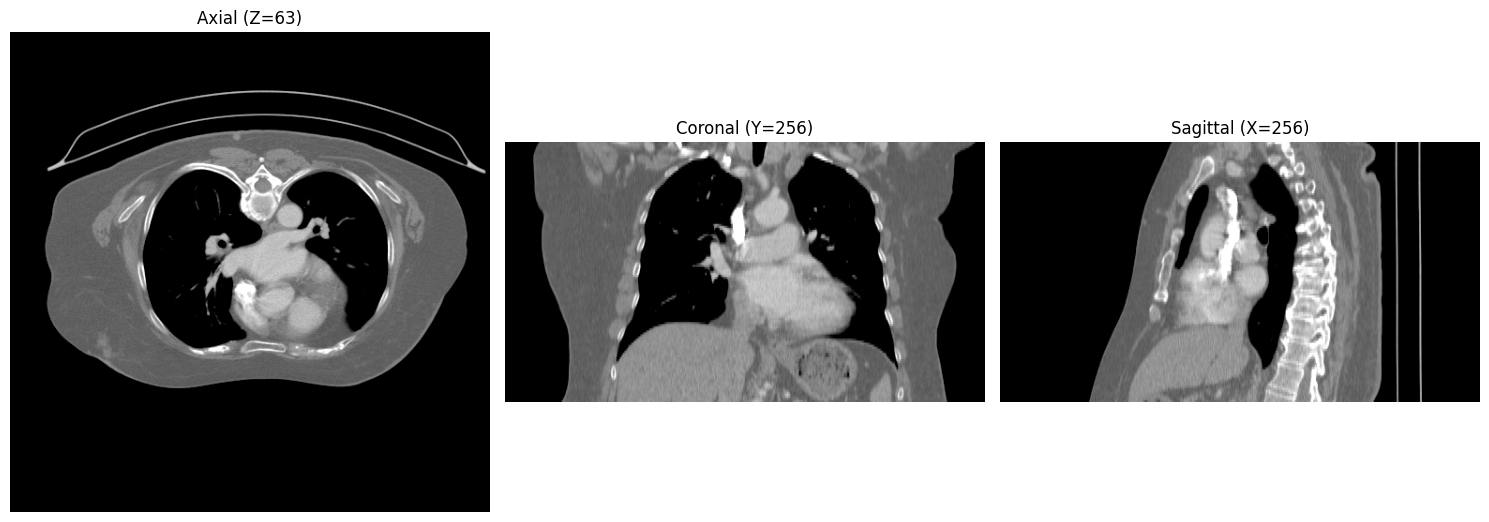

In [27]:
# --- 4. 시각화 (Soft Tissue Window 적용) ---
def window_image(img, min_val=-450, max_val=450):
    return np.clip(img, min_val, max_val)

# 3면도 (Orthogonal View) 준비
z, y, x = array.shape
mid_z, mid_y, mid_x = z // 2, y // 2, x // 2

# 비율(Aspect Ratio) 맞추기 (픽셀이 정사각형이 아닐 수 있음)
sp = image.GetSpacing()
aspect_ax = sp[1] / sp[0] 
aspect_cor = sp[2] / sp[0] # Z축 간격 반영
aspect_sag = sp[2] / sp[1] # Z축 간격 반영

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Axial (위에서 본 모습)
ax_img = window_image(array[mid_z, :, :])
axes[0].imshow(ax_img, cmap='gray', origin='lower', aspect=aspect_ax)
axes[0].set_title(f'Axial (Z={mid_z})')

# Coronal (앞에서 본 모습) - 상하반전 처리
cor_img = window_image(np.flipud(array[:, mid_y, :]))
axes[1].imshow(cor_img, cmap='gray', aspect=aspect_cor)
axes[1].set_title(f'Coronal (Y={mid_y})')

# Sagittal (옆에서 본 모습) - 상하반전 처리
sag_img = window_image(np.flipud(array[:, :, mid_x]))
axes[2].imshow(sag_img, cmap='gray', aspect=aspect_sag)
axes[2].set_title(f'Sagittal (X={mid_x})')

for ax in axes: ax.axis('off')
plt.tight_layout()
plt.show()

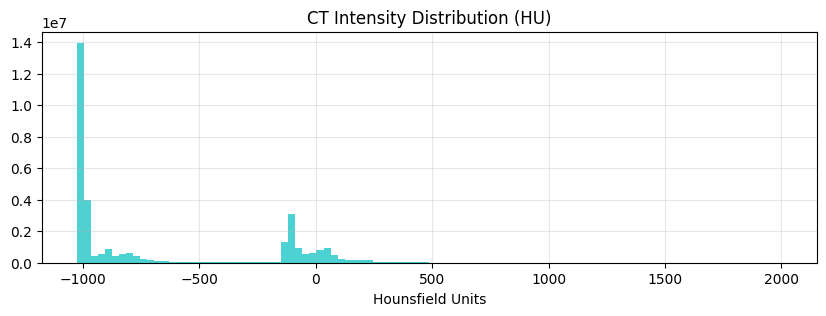

In [28]:
# --- 5. 히스토그램 (값 분포 확인) ---
plt.figure(figsize=(10, 3))
plt.hist(array.flatten(), bins=100, range=(-1024, 2000), color='c', alpha=0.7)
plt.title("CT Intensity Distribution (HU)")
plt.xlabel("Hounsfield Units")
plt.grid(True, alpha=0.3)
plt.show()

In [29]:
# --- 6. 인터랙티브 슬라이더 ---
def explore_slices(slice_idx):
    plt.figure(figsize=(6, 6))
    # 보고 싶은 슬라이스만 윈도우 적용
    img_view = window_image(array[slice_idx, :, :])
    plt.imshow(img_view, cmap='gray', origin='lower')
    plt.title(f"Axial Slice: {slice_idx}")
    plt.axis('off')
    plt.show()

interact(explore_slices, slice_idx=IntSlider(min=0, max=z-1, step=1, value=mid_z));

interactive(children=(IntSlider(value=63, description='slice_idx', max=126), Output()), _dom_classes=('widget-…

### Resample to 3x3x3

In [47]:
import SimpleITK as sitk
import os
import glob
import numpy as np
from tqdm import tqdm

In [66]:
# --- Configuration ---
BASE_DIR = "/gpfs/accounts/jjparkcv_root/jjparkcv98/minsukc/Coltea-Lung-CT-100W"
INPUT_DIR = os.path.join(BASE_DIR, "data_nifti")       # 원본 NIfTI 폴더
OUTPUT_DIR = os.path.join(BASE_DIR, "data_nifti_3mm")  # 저장될 폴더 (3mm)

TARGET_SPACING = (3.0, 3.0, 3.0)  # 목표 해상도 (mm)

In [67]:
def resample_subject_volumes(subject_path, output_subject_path, target_spacing=(3.0, 3.0, 3.0)):
    # 1. 해당 환자 폴더 내의 파일들 찾기
    volume_paths = glob.glob(os.path.join(subject_path, "*.nii.gz"))
    if not volume_paths:
        return

    # 2. 기준(Reference)이 될 Native 영상 찾기
    # native가 없으면 목록의 첫 번째 파일을 기준으로 삼습니다.
    native_path = next((p for p in volume_paths if "native" in os.path.basename(p).lower()), volume_paths[0])
    
    # 3. 기준 영상(Native) 로드 및 새로운 정보 계산
    ref_img = sitk.ReadImage(native_path)
    orig_spacing = ref_img.GetSpacing()
    orig_size = ref_img.GetSize()
    
    new_size = [
        int(round(osz * ospc / tspc))
        for osz, ospc, tspc in zip(orig_size, orig_spacing, target_spacing)
    ]

    # 4. 모든 Phase(native, venous, arterial)를 동일한 틀로 변환
    for v_path in volume_paths:
        img = sitk.ReadImage(v_path)
        file_name = os.path.basename(v_path)
        save_path = os.path.join(output_subject_path, file_name)

        # 리샘플러 설정
        resampler = sitk.ResampleImageFilter()
        resampler.SetOutputSpacing(target_spacing)
        resampler.SetSize(new_size) 
        resampler.SetOutputOrigin(ref_img.GetOrigin()) 
        resampler.SetOutputDirection(ref_img.GetDirection())
        resampler.SetInterpolator(sitk.sitkLinear)
        resampler.SetOutputPixelType(img.GetPixelIDValue())

        # 실행 및 저장
        resampled_img = resampler.Execute(img)
        sitk.WriteImage(resampled_img, save_path)

# --- Main Processing Loop ---
# 환자 폴더 단위로 루프를 돕니다 (train/val/test 구조 유지)
for split in ["train", "val", "test"]:
    split_path = os.path.join(INPUT_DIR, split)
    if not os.path.exists(split_path): continue
    
    subjects = [d for d in os.listdir(split_path) if os.path.isdir(os.path.join(split_path, d))]
    
    for subj in tqdm(subjects, desc=f"Resampling {split}"):
        subj_in_path = os.path.join(split_path, subj)
        subj_out_path = os.path.join(OUTPUT_DIR, split, subj)
        os.makedirs(subj_out_path, exist_ok=True)
        
        resample_subject_volumes(subj_in_path, subj_out_path, TARGET_SPACING)

print(f"🎉 All subjects are now perfectly aligned in {OUTPUT_DIR}")

Resampling test: 100%|██████████████████████████████████████████████████████████████| 15/15 [00:42<00:00,  2.81s/it]

🎉 All subjects are now perfectly aligned in /gpfs/accounts/jjparkcv_root/jjparkcv98/minsukc/Coltea-Lung-CT-100W/data_nifti_3mm


In [68]:
import matplotlib.pyplot as plt
import random
import numpy as np
import SimpleITK as sitk
import os
import glob

# --- Helper Function: Min-Max Normalization ---
def minmax(arr, min_clip=-450, max_clip=450):
    """CT HU 값을 보기 좋게 정규화"""
    arr = np.clip(arr, min_clip, max_clip)
    arr = (arr - min_clip) / (max_clip - min_clip)
    return arr

# --- Helper Function: Show Comparison with Ratio ---
def compare_images(orig_path, res_path):
    # 1. 이미지 로드
    img_orig = sitk.ReadImage(orig_path)
    img_res = sitk.ReadImage(res_path)
    
    arr_orig = sitk.GetArrayFromImage(img_orig) # (Z, Y, X)
    arr_res = sitk.GetArrayFromImage(img_res)   # (Z, Y, X)
    
    # 2. 메타데이터 및 비율 계산
    sp_orig = img_orig.GetSpacing()
    sp_res = img_res.GetSpacing()
    sz_orig = img_orig.GetSize()
    sz_res = img_res.GetSize()
    
    # 복셀 수 계산 (Compute Load)
    voxels_orig = np.prod(sz_orig)
    voxels_res = np.prod(sz_res)
    ratio = voxels_res / voxels_orig
    
    # 3. 텍스트 출력
    print(f"\n📊 Comparison Report: {os.path.basename(orig_path)}")
    print("-" * 50)
    print(f"  🧠 Original Shape: {sz_orig[::-1]} (Z, Y, X)")
    print(f"  🧠 Resampled Shape: {sz_res[::-1]} (Z, Y, X)")
    print("-" * 50)
    print(f"  📉 Original Voxels:  {voxels_orig:,}")
    print(f"  📉 Resampled Voxels: {voxels_res:,}")
    
    # 변화율 출력 (화살표로 직관적 표시)
    if ratio < 1:
        print(f"  🚀 Compute Change Ratio: {ratio:.4f}x (↓ {(1-ratio)*100:.1f}% lighter)")
    else:
        print(f"  🐌 Compute Change Ratio: {ratio:.4f}x (↑ {(ratio-1)*100:.1f}% heavier)")
    print("-" * 50)

    # 4. 시각화 (중간 슬라이스)
    z1 = arr_orig.shape[0] // 2
    z2 = arr_res.shape[0] // 2
    
    slice_orig = minmax(arr_orig[z1, :, :])
    slice_res = minmax(arr_res[z2, :, :])
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 7))
    
    # Original
    axes[0].imshow(slice_orig, cmap="gray", origin="lower")
    axes[0].set_title(f"Original\nSlice: {z1}, Spacing: {sp_orig[2]:.2f}mm")
    axes[0].axis("off")
    
    # Resampled
    axes[1].imshow(slice_res, cmap="gray", origin="lower")
    axes[1].set_title(f"Resampled (3mm)\nSlice: {z2}, Spacing: {sp_res[2]:.2f}mm")
    axes[1].axis("off")
    
    plt.tight_layout()
    plt.show()


📊 Comparison Report: venous.nii.gz
--------------------------------------------------
  🧠 Original Shape: (88, 512, 512) (Z, Y, X)
  🧠 Resampled Shape: (88, 137, 137) (Z, Y, X)
--------------------------------------------------
  📉 Original Voxels:  23,068,672
  📉 Resampled Voxels: 1,651,672
  🚀 Compute Change Ratio: 0.0716x (↓ 92.8% lighter)
--------------------------------------------------


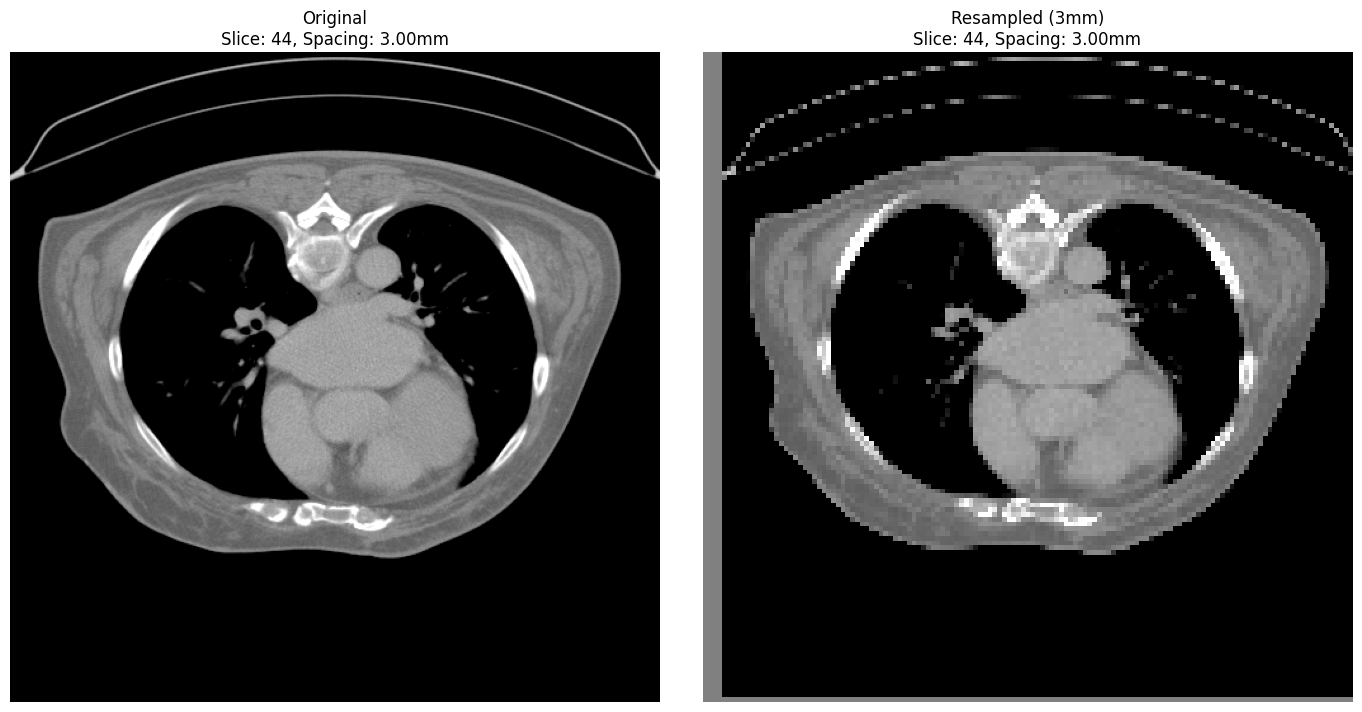

In [71]:
# --- Run Visualization ---
BASE_DIR = "/gpfs/accounts/jjparkcv_root/jjparkcv98/minsukc/Coltea-Lung-CT-100W"
INPUT_DIR = os.path.join(BASE_DIR, "data_nifti") 
OUTPUT_DIR = os.path.join(BASE_DIR, "data_nifti_3mm")

# 3mm 폴더에서 파일 하나를 랜덤으로 골라 비교
resampled_files = glob.glob(os.path.join(OUTPUT_DIR, "**", "*.nii.gz"), recursive=True)

if resampled_files:
    target_file = random.choice(resampled_files)
    
    # 원본 파일 경로 역추적 (상대 경로 이용)
    relative = os.path.relpath(target_file, OUTPUT_DIR)
    original_file = os.path.join(INPUT_DIR, relative)
    
    if os.path.exists(original_file):
        compare_images(original_file, target_file)
    else:
        print(f"❌ Original file not found: {original_file}")
else:
    print("❌ No resampled files found. Run the batch script first!")